# Style transfer using GAN
This notebook will be used to prepare the capstone project 'Style transfer using GAN'

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
#Import all the required libraries

#Import all the required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import random
from skimage import io

import time

## Data understanding
Import the images & create two seperate datasets. The input shape for image should be (256, 256)


In [33]:
tr1 = tf.keras.preprocessing.image_dataset_from_directory(f'/content/drive/My Drive/Colab Notebooks/dataset/Tr1/', 
                                                          labels='inferred', label_mode='int',
    class_names=None, color_mode='grayscale', batch_size=1, image_size=(256,
    256), shuffle=False, seed=42, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False)


Found 43 files belonging to 1 classes.


In [34]:
tr2 = tf.keras.preprocessing.image_dataset_from_directory(f'/content/drive/My Drive/Colab Notebooks/dataset/Tr2/', 
                                                          labels='inferred', label_mode='int',
    class_names=None, color_mode='grayscale', batch_size=1, image_size=(256,
    256), shuffle=False, seed=42, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False)


Found 46 files belonging to 1 classes.


## Image Processing 
1.Create a function to process your images with normalisation

2.Apply the function to both the datasets 

3.Visualise the MRI images after processing




In [35]:
# normalizing the images to [-1, 1]
def normalize(image):
    image =  (image / 127.5) - 1
    return image

In [36]:
def preprocess_image_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = normalize(image)
    return image

In [37]:
# process both classes of MRI images

tr1 = tr1.map(preprocess_image_train)
tr2 = tr2.map(preprocess_image_train) 

In [38]:
sample_tr1 = next(iter(tr1))
sample_tr2 = next(iter(tr2))

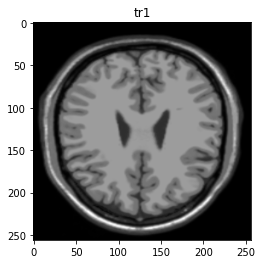

In [39]:
plt.title('tr1')
plt.imshow(sample_tr1[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

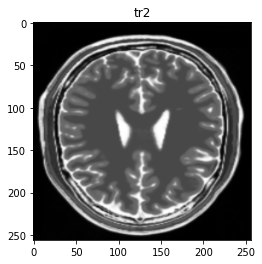

In [40]:
plt.title('tr2')
plt.imshow(sample_tr2[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

## Model Building & Training
The architecture of generator is a modified U-Net.

1.Create your Generator & Discriminator

2.Define the loss functions

3.Create the train_step function

In [41]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(InstanceNormalization())
    result.add(tf.keras.layers.PReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [42]:
def unet_generator():
      inputs = tf.keras.layers.Input(shape=[256,256,1])

      down_stack = [
        downsample(64, 4, apply_norm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
      ]

      up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
      ]

      initializer = tf.random_normal_initializer(0., 0.02)
      last = tf.keras.layers.Conv2DTranspose(1, 4,
                                            strides=2,
                                            padding='same',
                                            kernel_initializer=initializer,
                                            activation='tanh') # (bs, 256, 256, 3)

      x = inputs

      # Downsampling through the model
      skips = []
      for down in down_stack:
        x = down(x)
        skips.append(x)

      skips = reversed(skips[:-1])

      # Upsampling and establishing the skip connections
      for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

      x = last(x)

      return tf.keras.Model(inputs=inputs, outputs=x)
        

In [43]:
generator_g = unet_generator()   #initialise the generator
generator_f = unet_generator()   #initialise the generator

In [44]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256,256, 1], name='input_image')
    x = inp
    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.PReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    return tf.keras.Model(inputs=[inp], outputs=last)   #create the model using input & output layer

In [45]:
discriminator_x = discriminator() #initialise the discriminator
discriminator_y = discriminator() #initialise the discriminator

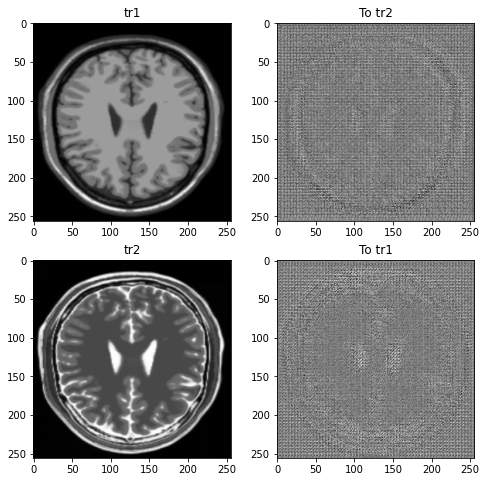

In [46]:
to_tr2 = generator_g(sample_tr1)
to_tr1 = generator_f(sample_tr2)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_tr1, to_tr2, sample_tr2, to_tr1]
title = ['tr1', 'To tr2', 'tr2', 'To tr1']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 * contrast + 0.5, cmap='gray')
plt.show()

In [47]:
LAMBDA = 10 #"Your Lambda Value Here"

In [48]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True) #"Your Binary-Cross-Entropy Loss Here"

In [49]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

In [50]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [51]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [52]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [53]:
generator_g_optimizer = tf.keras.optimizers.Adam(0.0015, beta_1=0.5,beta_2=0.999)
generator_f_optimizer = tf.keras.optimizers.Adam(0.0015, beta_1=0.5,beta_2=0.999)

discriminator_x_optimizer = tf.keras.optimizers.Adam(0.0015, beta_1=0.5,beta_2=0.999)
discriminator_y_optimizer = tf.keras.optimizers.Adam(0.0015, beta_1=0.5,beta_2=0.999)

In [54]:
EPOCHS = 75

In [55]:
checkpoint_path =  "/content/drive/My Drive/checkpoints/train/3"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=EPOCHS)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [56]:
def generate_images(model, test_input, expected_output):
    prediction = model(test_input)
    plt.figure(figsize=(10, 10))
    display_list = [test_input[0], prediction[0], expected_output[0]]
    title = ['Input Image', 'Predicted Image', 'Expected Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

In [57]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables) #write your code here
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables) #write your code here
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables) #write your code here
    
    # Apply the gradients to the optimizer
    
    #write your code here
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients,generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients,generator_f.trainable_variables))
                                            

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,discriminator_y.trainable_variables))


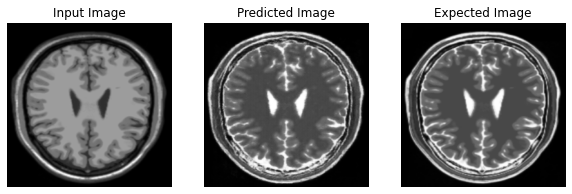

Time taken in 39.752909898757935 seconds for epoch 1



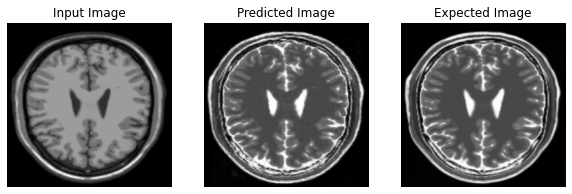

Time taken in 19.07805824279785 seconds for epoch 2



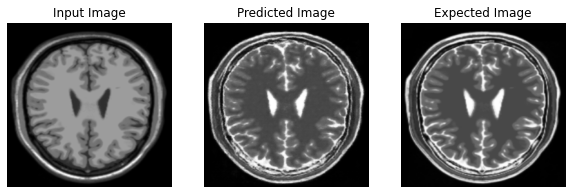

Time taken in 19.121886491775513 seconds for epoch 3



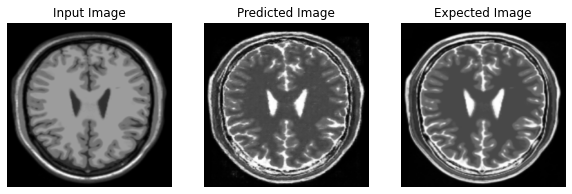

Time taken in 18.905914306640625 seconds for epoch 4



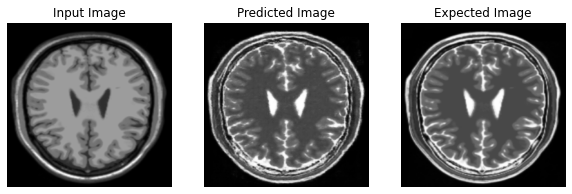

Time taken in 18.84661078453064 seconds for epoch 5



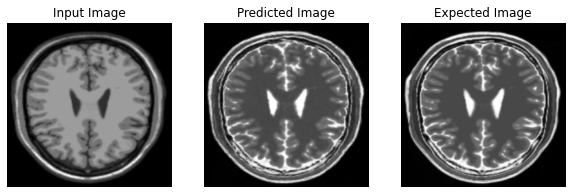

Time taken in 18.92656111717224 seconds for epoch 6



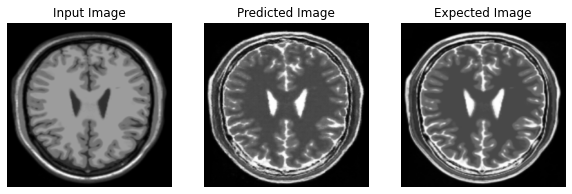

Time taken in 19.02243947982788 seconds for epoch 7



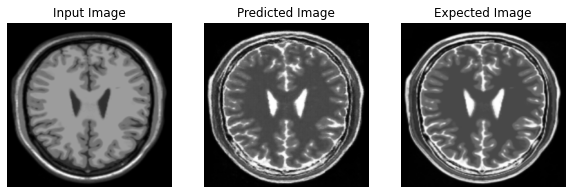

Time taken in 18.96514868736267 seconds for epoch 8



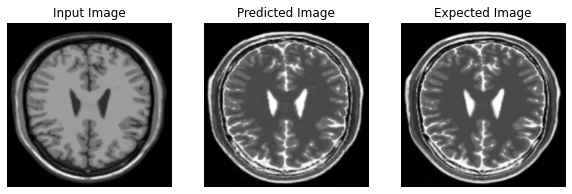

Time taken in 18.91927456855774 seconds for epoch 9



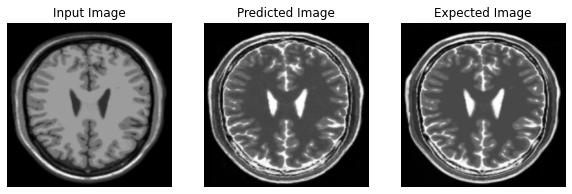

Time taken in 18.95149517059326 seconds for epoch 10



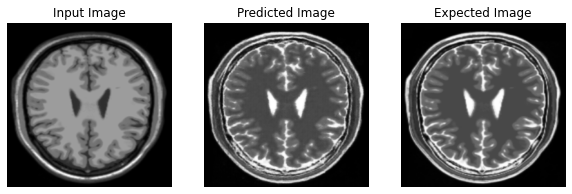

Time taken in 19.00780963897705 seconds for epoch 11



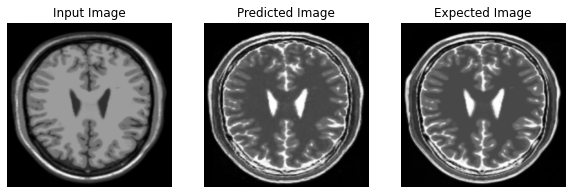

Time taken in 18.974222898483276 seconds for epoch 12



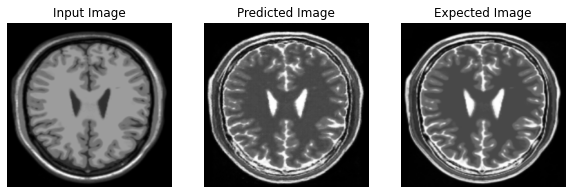

Time taken in 18.962697744369507 seconds for epoch 13



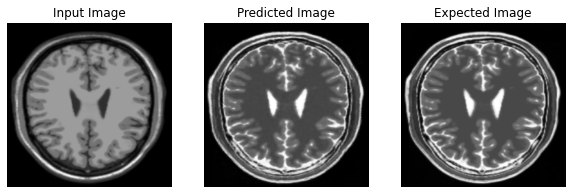

Time taken in 18.94447112083435 seconds for epoch 14



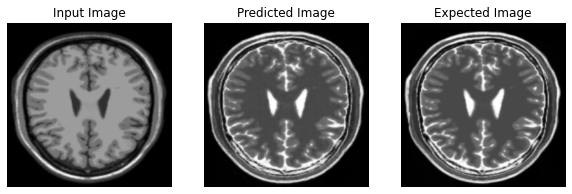

Time taken in 18.953274250030518 seconds for epoch 15



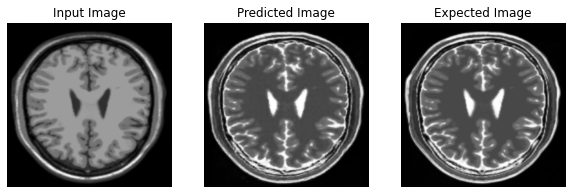

Time taken in 18.950226306915283 seconds for epoch 16



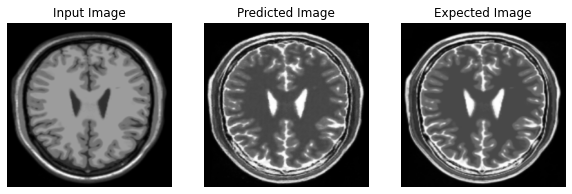

Time taken in 18.966247081756592 seconds for epoch 17



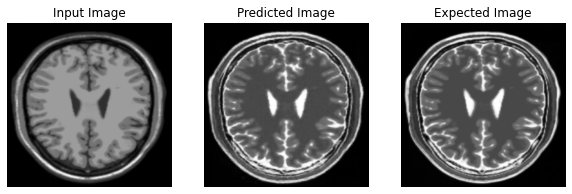

Time taken in 18.963525772094727 seconds for epoch 18



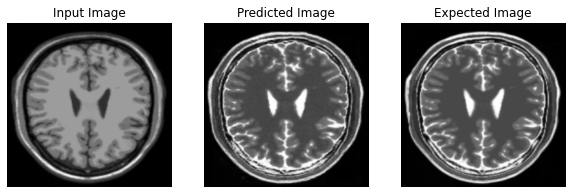

Time taken in 18.97192668914795 seconds for epoch 19



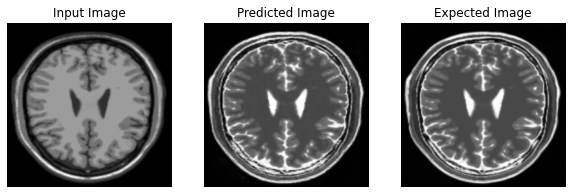

Time taken in 19.313852787017822 seconds for epoch 20



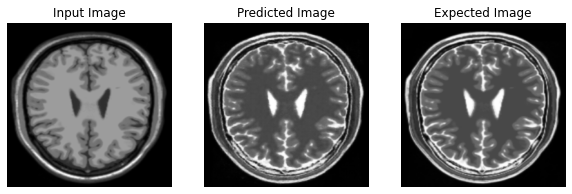

Time taken in 18.962045431137085 seconds for epoch 21



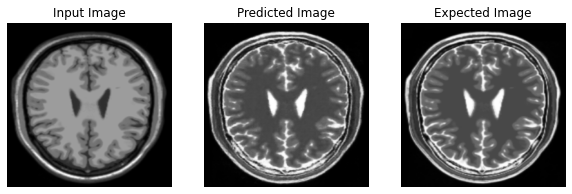

Time taken in 18.960115432739258 seconds for epoch 22



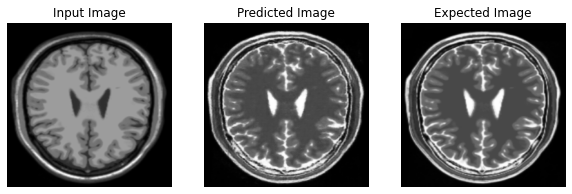

Time taken in 18.956268787384033 seconds for epoch 23



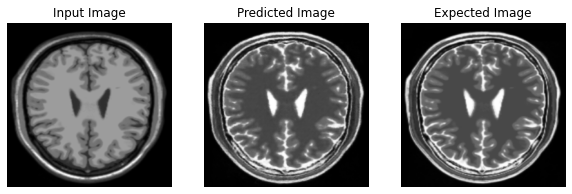

Time taken in 18.96138048171997 seconds for epoch 24



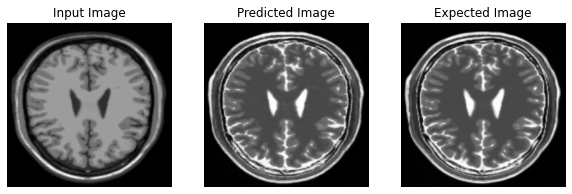

Saving checkpoint for epoch 25 at /content/drive/My Drive/checkpoints/train/3/ckpt-3
Time taken in 26.98423981666565 seconds for epoch 25



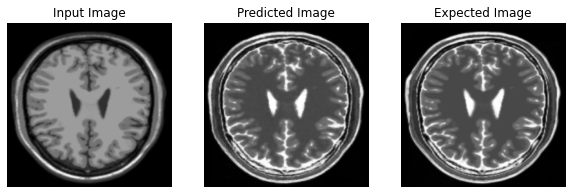

Time taken in 18.952608823776245 seconds for epoch 26



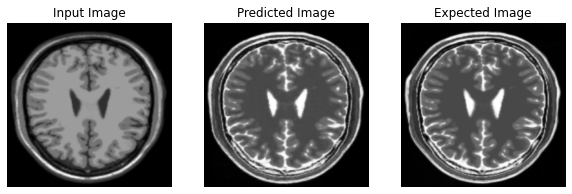

Time taken in 19.074466466903687 seconds for epoch 27



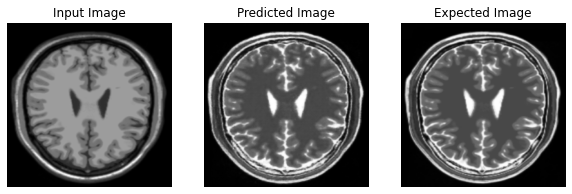

Time taken in 18.966575860977173 seconds for epoch 28



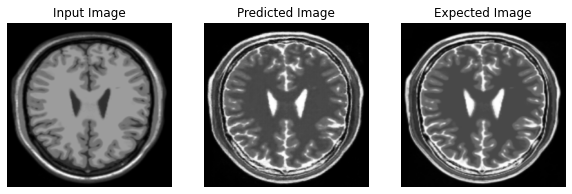

Time taken in 18.92020559310913 seconds for epoch 29



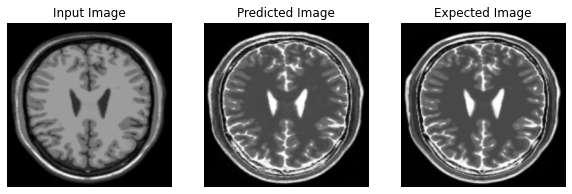

Time taken in 18.932952642440796 seconds for epoch 30



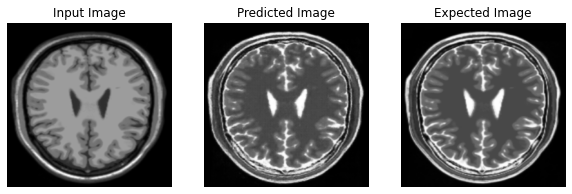

Time taken in 18.9683358669281 seconds for epoch 31



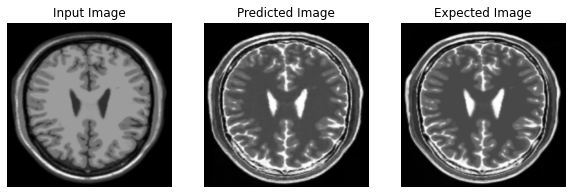

Time taken in 18.953922271728516 seconds for epoch 32



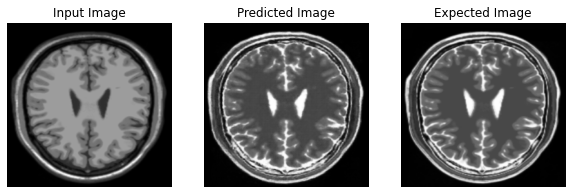

Time taken in 18.951844453811646 seconds for epoch 33



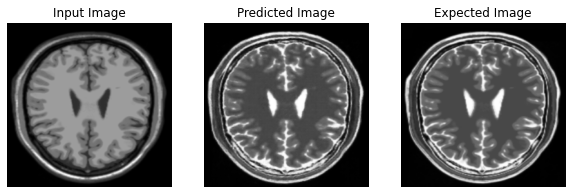

Time taken in 18.937759160995483 seconds for epoch 34



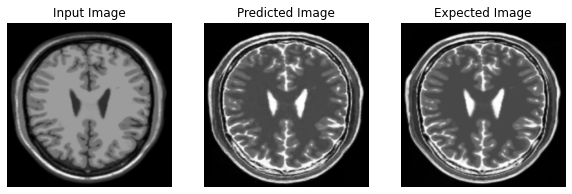

Time taken in 18.975956439971924 seconds for epoch 35



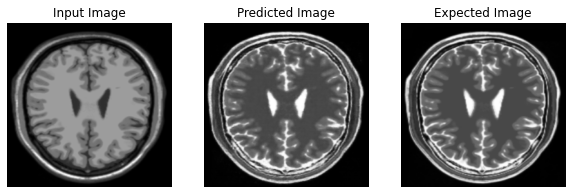

Time taken in 18.93627405166626 seconds for epoch 36



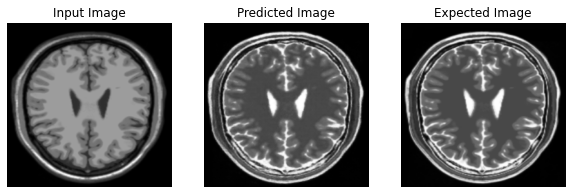

Time taken in 18.938312292099 seconds for epoch 37



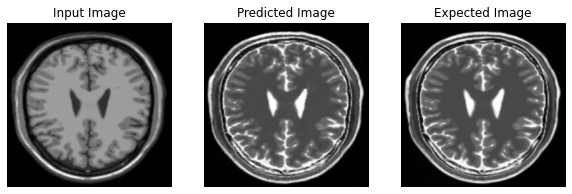

Time taken in 18.9335994720459 seconds for epoch 38



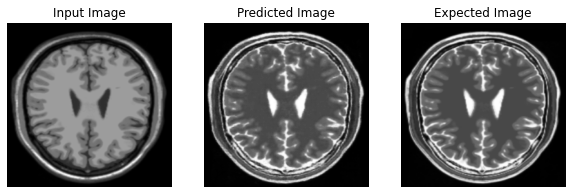

Time taken in 18.94488263130188 seconds for epoch 39



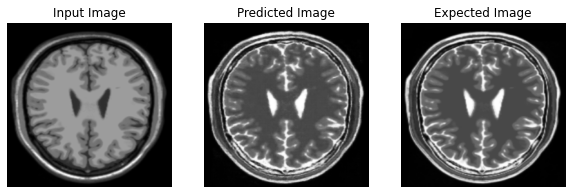

Time taken in 18.937434911727905 seconds for epoch 40



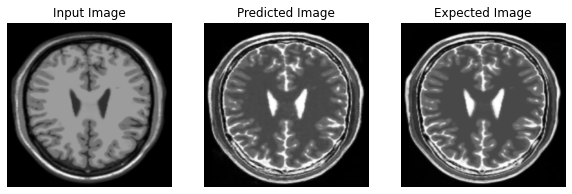

Time taken in 18.9637188911438 seconds for epoch 41



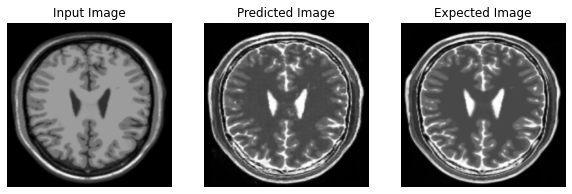

Time taken in 18.982147455215454 seconds for epoch 42



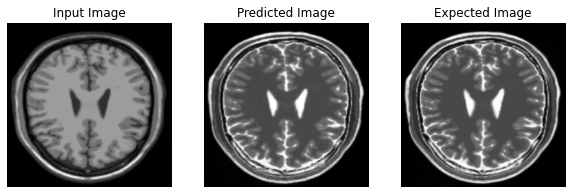

Time taken in 18.954223155975342 seconds for epoch 43



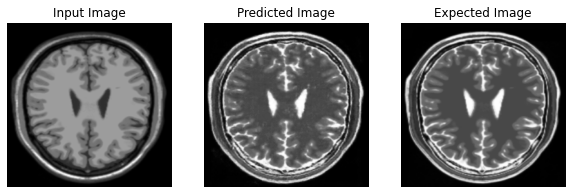

Time taken in 18.995204210281372 seconds for epoch 44



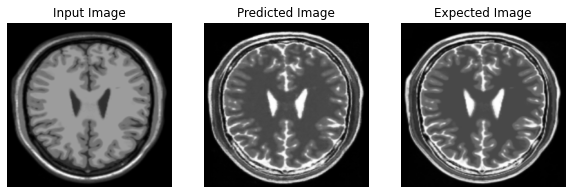

Time taken in 18.984349489212036 seconds for epoch 45



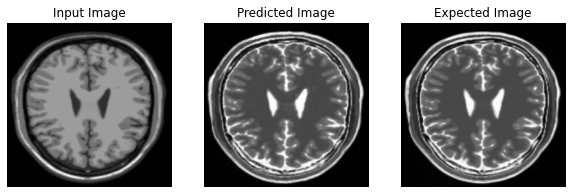

Time taken in 18.964897632598877 seconds for epoch 46



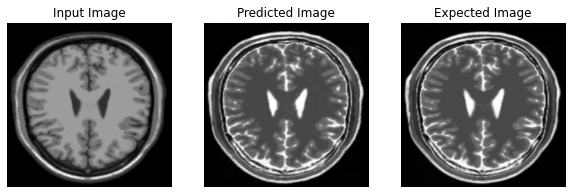

Time taken in 18.95193338394165 seconds for epoch 47



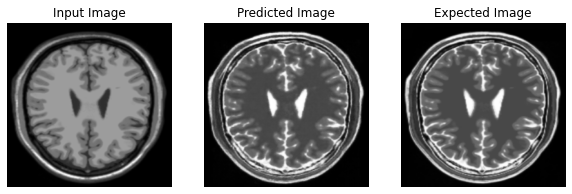

Time taken in 18.97453260421753 seconds for epoch 48



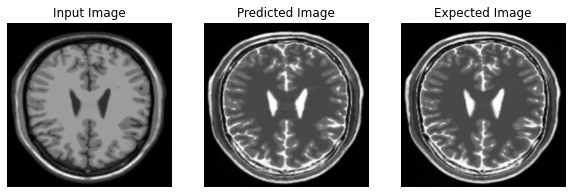

Time taken in 18.986515283584595 seconds for epoch 49



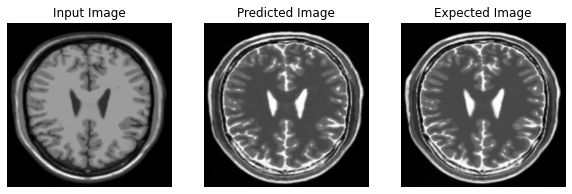

Saving checkpoint for epoch 50 at /content/drive/My Drive/checkpoints/train/3/ckpt-4
Time taken in 25.361517190933228 seconds for epoch 50



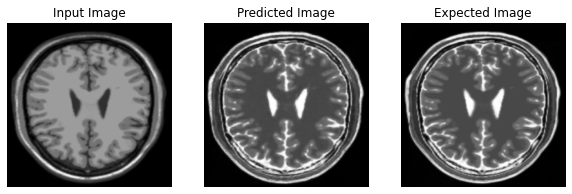

Time taken in 18.987616062164307 seconds for epoch 51



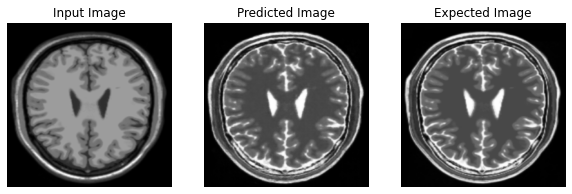

Time taken in 19.084124326705933 seconds for epoch 52



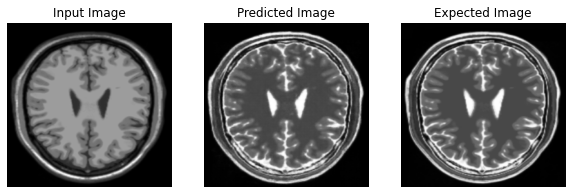

Time taken in 18.951417922973633 seconds for epoch 53



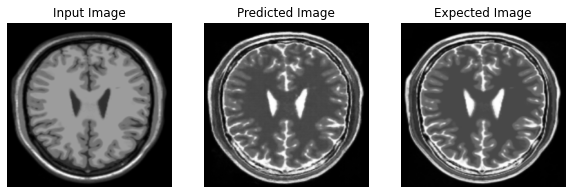

Time taken in 18.929567098617554 seconds for epoch 54



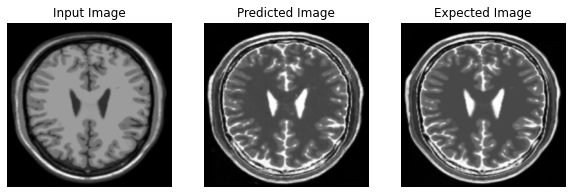

Time taken in 18.969491958618164 seconds for epoch 55



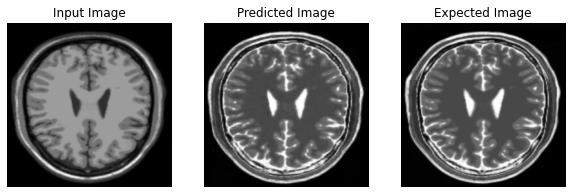

Time taken in 18.995840311050415 seconds for epoch 56



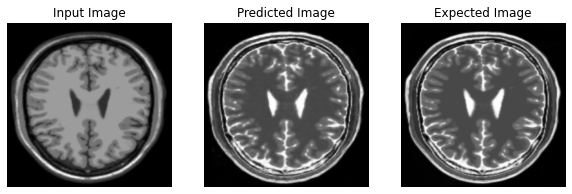

Time taken in 18.963553428649902 seconds for epoch 57



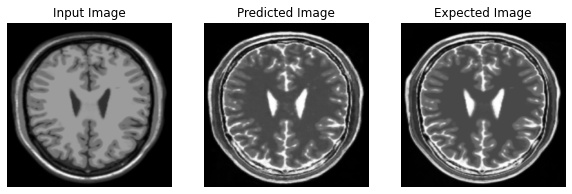

Time taken in 19.300789833068848 seconds for epoch 58



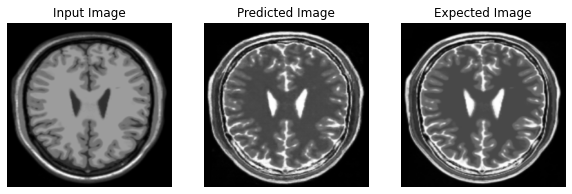

Time taken in 18.912023782730103 seconds for epoch 59



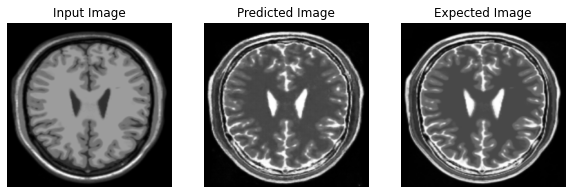

Time taken in 18.93238878250122 seconds for epoch 60



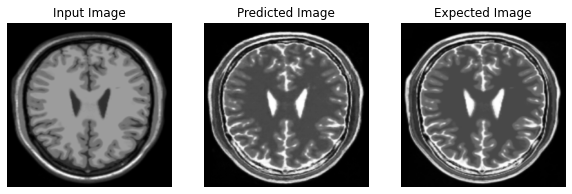

Time taken in 18.95909571647644 seconds for epoch 61



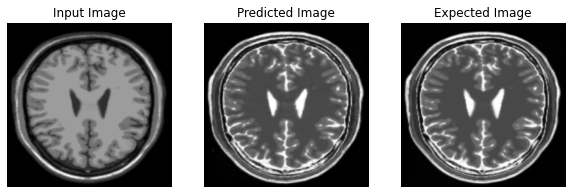

Time taken in 18.953524351119995 seconds for epoch 62



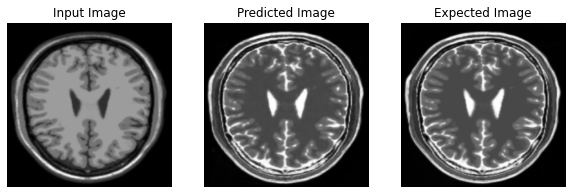

Time taken in 18.92930006980896 seconds for epoch 63



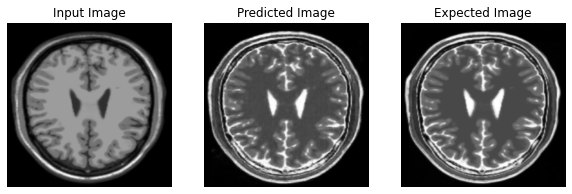

Time taken in 18.919414520263672 seconds for epoch 64



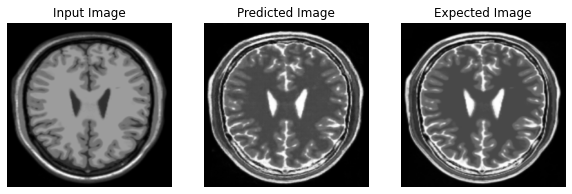

Time taken in 18.927141904830933 seconds for epoch 65



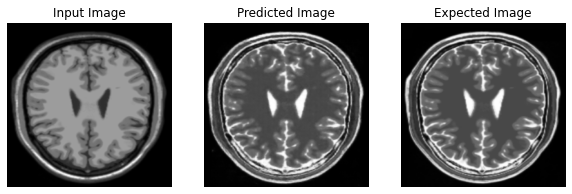

Time taken in 18.939766883850098 seconds for epoch 66



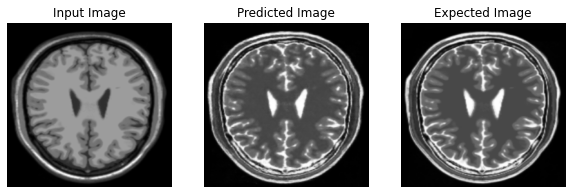

Time taken in 18.921870470046997 seconds for epoch 67



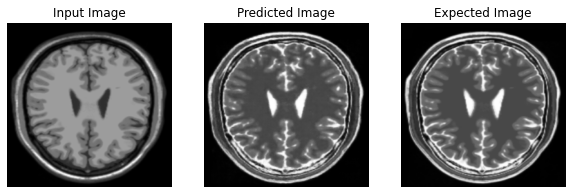

Time taken in 18.919185400009155 seconds for epoch 68



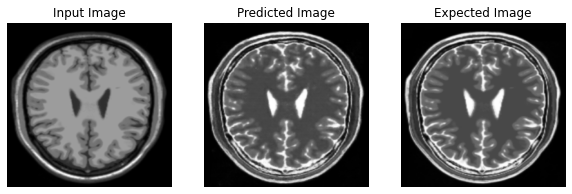

Time taken in 18.92408037185669 seconds for epoch 69



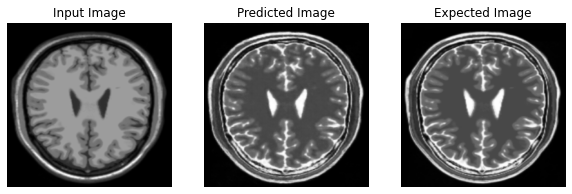

Time taken in 18.933701038360596 seconds for epoch 70



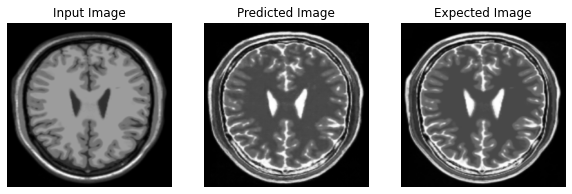

Time taken in 18.94316530227661 seconds for epoch 71



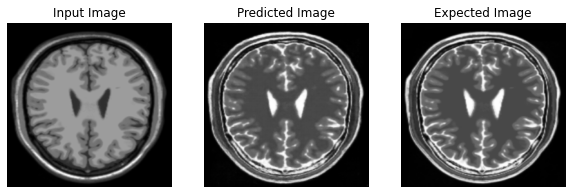

Time taken in 18.975888967514038 seconds for epoch 72



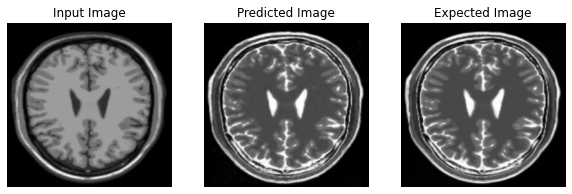

Time taken in 18.953947067260742 seconds for epoch 73



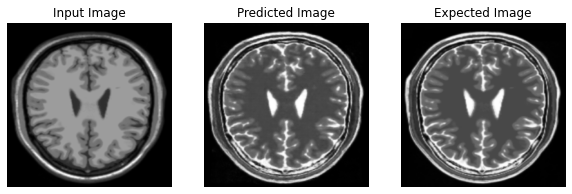

Time taken in 18.934622764587402 seconds for epoch 74



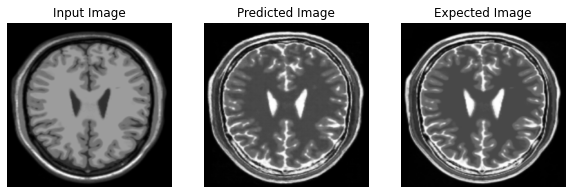

Saving checkpoint for epoch 75 at /content/drive/My Drive/checkpoints/train/3/ckpt-5
Time taken in 26.019559860229492 seconds for epoch 75



In [58]:
#0.0015
for epoch in range(EPOCHS):
    start = time.time()
    for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):
        train_step(image_x, image_y)
    if (epoch + 1) % 1 == 0:
        generate_images(generator_g, sample_tr1, sample_tr2)
    if (epoch + 1) % 25 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
    print ('Time taken in {} seconds for epoch {}\n'.format((time.time()-start),epoch + 1))

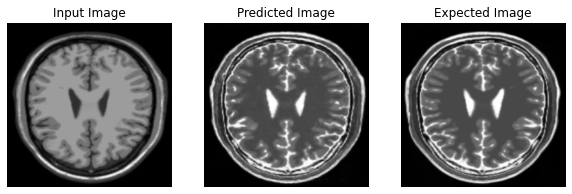

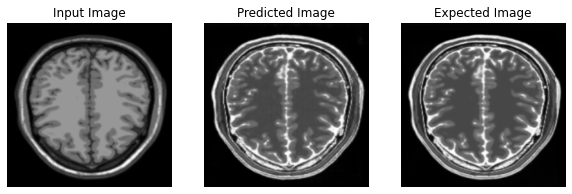

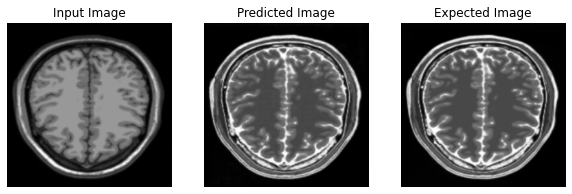

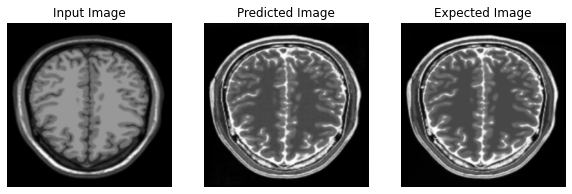

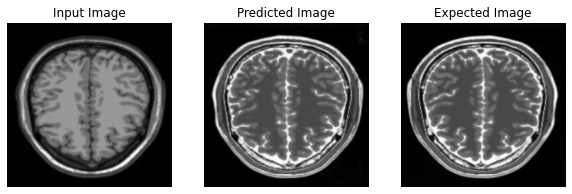

In [59]:
import itertools
for (inp,out) in itertools.zip_longest(tr1.take(5), tr2.take(5)):
    generate_images(generator_g, inp, out)